**Smile Classification from face images using a CNN:**
- Goal is to build and train a cnn model for predicting the smile attribute from face images in the celeba dataset. We will be using a small portion of the training data (16k training examples) to speed up the training process. 

In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn

In [2]:
import torchvision

In [10]:
import pandas as pd

In [17]:
from torch.utils.data import Dataset, DataLoader, Subset

In [21]:
from PIL import Image

**Load the celeba dataset:**
- First, lets load the data. Data comes in 3 partitions, a training set, validation set, and test set. Next, we count the number of examples in each partition.

In [33]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, attr_path, partition_path, split='train', target_attr='Smiling',transform=None):
        self.root_dir = root_dir
        self.attr_df = pd.read_csv(attr_path)
        self.partition_df = pd.read_csv(partition_path)
        self.target_attr = target_attr
        self.transform = transform
        split_map = {"train":0, "val": 1, "test": 2}
        split_id = split_map[split]

        mask = self.partition_df['partition'] == split_id
        self.image_ids = self.partition_df[mask]["image_id"].values
        self.attr_df.set_index("image_id",inplace=True)
    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        img_name = self.image_ids[index]
        img_path = os.path.join(self.root_dir,img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.attr_df.loc[img_name, self.target_attr]
        label = int((label+1)/2)
        return image,label     

    

In [34]:
celeba_train_dataset = CelebADataset(root_dir='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba',
                                    attr_path='/kaggle/input/celeba-dataset/list_attr_celeba.csv',
                                    partition_path='/kaggle/input/celeba-dataset/list_eval_partition.csv',
                )

celeba_valid_dataset = CelebADataset(root_dir='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba',
                                    attr_path='/kaggle/input/celeba-dataset/list_attr_celeba.csv',
                                    partition_path='/kaggle/input/celeba-dataset/list_eval_partition.csv',
                                    split="val"
                )

celeba_test_dataset = CelebADataset(root_dir='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba',
                                    attr_path='/kaggle/input/celeba-dataset/list_attr_celeba.csv',
                                    partition_path='/kaggle/input/celeba-dataset/list_eval_partition.csv',
                                    split="test"
                )

In [35]:
print('Train set: ',len(celeba_train_dataset))
print('Valid set: ',len(celeba_valid_dataset))
print('Test set: ',len(celeba_test_dataset))

Train set:  162770
Valid set:  19867
Test set:  19962


**Image Transformation and Data augmentation:**
- Data aumentation summarizes a broad set of techniques for dealing with cases where the training data is limited. Certain data augmentation techniques allow us to modify or even artificially synthesize more data and thereby boost the performance of a machine learning or deep learning technique.
- We will apply some test transformations for the data below

In [36]:
import matplotlib.pyplot as plt

In [37]:
import os

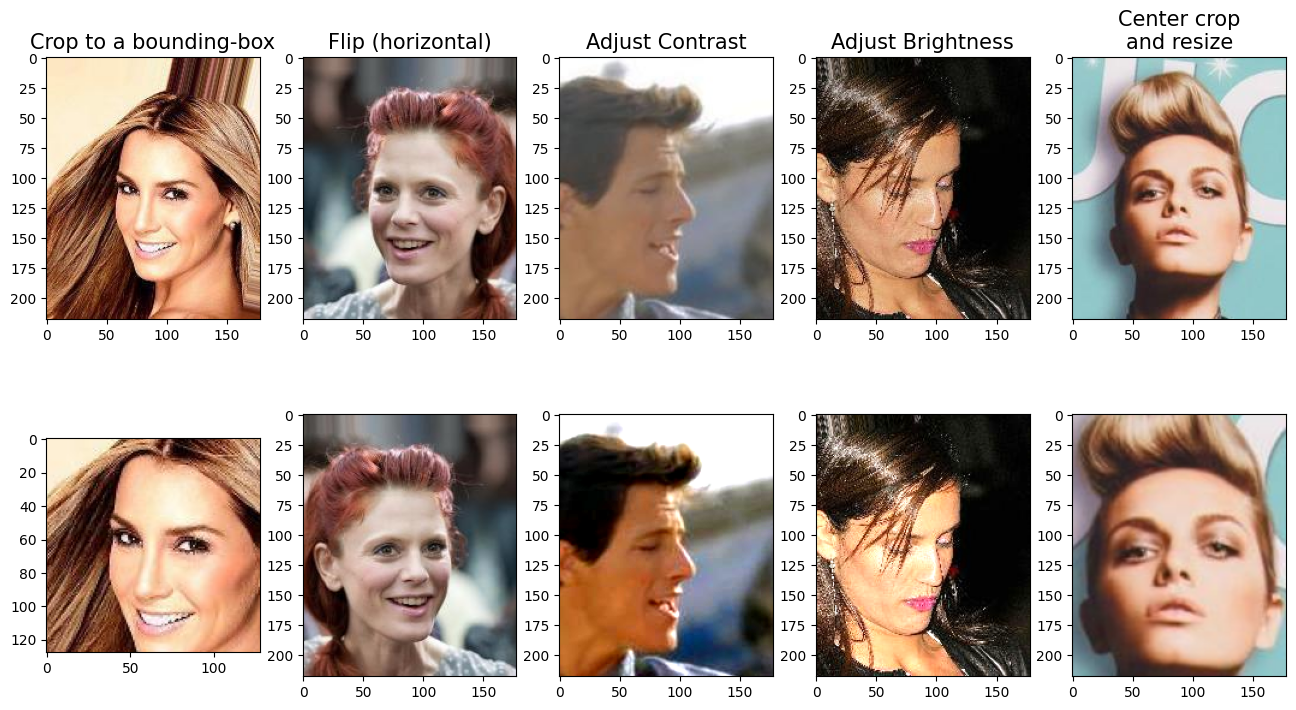

In [42]:
fig = plt.figure(figsize=(16,8.5))
### Column 1: Cropping to a bounding box
ax = fig.add_subplot(2,5,1)
img, attr = celeba_train_dataset[0]
ax.set_title("Crop to a bounding-box", size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2,5,2)
img, attr = celeba_train_dataset[1]
ax.set_title("Flip (horizontal)",size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

### Column 3: adjust contrast
ax = fig.add_subplot(2,5,3)
img, attr = celeba_train_dataset[2]
ax.set_title("Adjust Contrast",size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,8)
img_adj_contrast = transforms.functional.adjust_contrast(
    img, contrast_factor=2
)
ax.imshow(img_adj_contrast)

### Column 4: Adjust brightness
ax = fig.add_subplot(2,5,4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust Brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,9)
img_adj_brightness = transforms.functional.adjust_brightness(
    img, brightness_factor=1.3
)
ax.imshow(img_adj_brightness)

### Column 5: cropping from the image center
ax = fig.add_subplot(2,5,5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(
img, [0.7*218, 0.7*178]
)
img_resized = transforms.functional.resize(
 img_center_crop, size=(218, 178)
 )
ax.imshow(img_resized)
plt.show()


Combining the transformations:

we define the transform_train function that will produce the transformed image (where we will first randomly crop the image, then flip it randomly, then funally resize it to the resired 64x64

In [47]:
# we define the transform train function that will produce the transformed image 
transform_train = transforms.Compose([
    transforms.RandomCrop([178,178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64,64]),
    transforms.ToTensor()
])
# we will only apply data augmentation to the training examples, however and not to the validation or test images.
# the code for validation or test set is as follows - where we first crop the image simply then resize it to the desired 64x64
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64,64]),
    transforms.ToTensor()
])


In [48]:
celeba_train_dataset = CelebADataset(root_dir='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba',
                                    attr_path='/kaggle/input/celeba-dataset/list_attr_celeba.csv',
                                    partition_path='/kaggle/input/celeba-dataset/list_eval_partition.csv',
                                    transform = transform_train
                )

In [49]:
torch.manual_seed(1)
data_loader = DataLoader(celeba_train_dataset, batch_size=2)

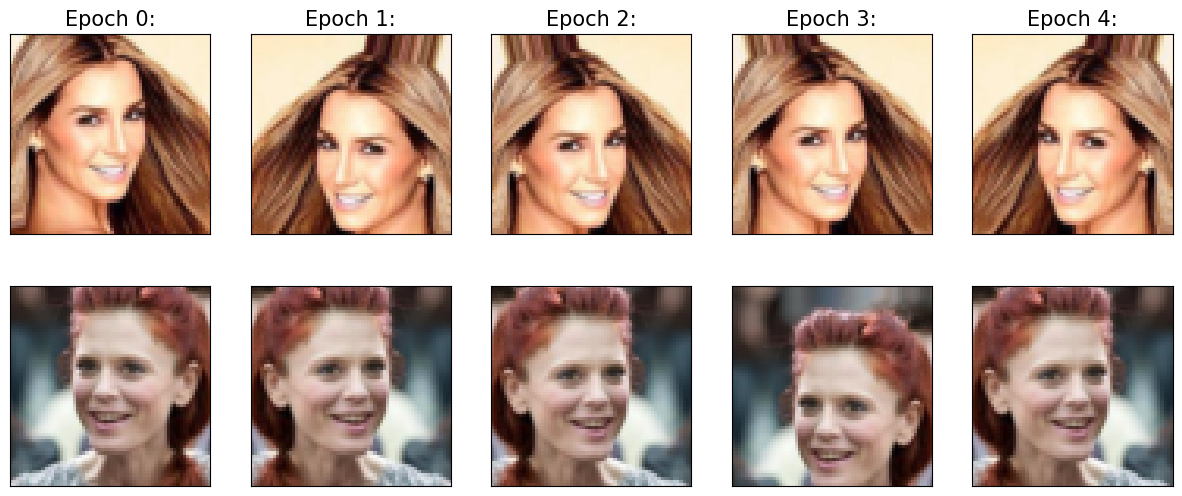

In [50]:
fig = plt.figure(figsize=(15, 6))
num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))

    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))
plt.show()

In [51]:
celeba_valid_dataset = CelebADataset(root_dir='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba',
                                    attr_path='/kaggle/input/celeba-dataset/list_attr_celeba.csv',
                                    partition_path='/kaggle/input/celeba-dataset/list_eval_partition.csv',
                                    split="val",
                                    transform = transform
                )

celeba_test_dataset = CelebADataset(root_dir='/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba',
                                    attr_path='/kaggle/input/celeba-dataset/list_attr_celeba.csv',
                                    partition_path='/kaggle/input/celeba-dataset/list_eval_partition.csv',
                                    split="test",
                                    transform=transform
                )

Furthermore, instead of using all the available training and validation data, we will take a subset of 16,000 training examples, and 1,000 training examples for validation, as our goal is to intentionally train a model with a small dataset:

In [52]:
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000))
print('Train set: ', len(celeba_train_dataset))
print('Validation set: ',len(celeba_valid_dataset))

Train set:  16000
Validation set:  1000


In [53]:
# now we create a dataloader for the 3 datasets:
batch_size = 32
torch.manual_seed(1)

train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

In [54]:
celeba_train_dataset[0][0].shape

torch.Size([3, 64, 64])

**Training a CNN smile classifier:**

In [55]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=3, out_channels=32,
        kernel_size=3,padding='same'
    )
)
model.add_module('relu1',nn.ReLU())
model.add_module('pool1',nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1',nn.Dropout(p=0.5))

model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=3,padding='same'
    )
)
model.add_module('relu2',nn.ReLU())
model.add_module('pool2',nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2',nn.Dropout(p=0.5))

model.add_module(
    'conv3',
    nn.Conv2d(
        in_channels=64,out_channels=128,
        kernel_size=3,padding='same'
    )
)
model.add_module('relu3',nn.ReLU())
model.add_module('pool3',nn.MaxPool2d(kernel_size=2))

model.add_module(
    'conv4',
    nn.Conv2d(
        in_channels=128, out_channels=256,
        kernel_size=3,padding='same'
    )
)
model.add_module('relu4',nn.ReLU())

In [56]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

There are 256 feature maps of size 8x8. We can either add a fully connected layer to get to the output layer with a single unit If we reshape (flatten) the feature maps, the number of input units to the fully connected layer will be: 8x8x256 = 16,384. Alternatively, we can add a new global average pooling layer - which computes the average of each feature map separately, thereby reducing the hidden units to 256.  We can then add a fully connected layer. 

In [57]:
# adding the global average pooling layer:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten',nn.Flatten())
model(x).shape

torch.Size([4, 256])

In [58]:
# finally, we can add a fully connected layer to get a single output unit. in this case we can specify the sigmoid activation function
model.add_module('fc', nn.Linear(256,1))
model.add_module('sigmoid', nn.Sigmoid())
model(x).shape

torch.Size([4, 1])

In [59]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [69]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [70]:
model = model.to(device)

In [74]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# now train the model with the following function
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0]*num_epochs
    accuracy_hist_train = [0]*num_epochs
    loss_hist_valid = [0]*num_epochs
    accuracy_hist_valid = [0]*num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to('cuda:0'), y_batch.to('cuda:0')
            pred = model(x_batch)[:,0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to('cuda:0'), y_batch.to('cuda:0')
                pred = model(x_batch)[:,0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch: {epoch+1} | accuracy: {accuracy_hist_train[epoch]:.4f} | val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
                

In [75]:
torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch: 1 | accuracy: 0.5367 | val_accuracy: 0.5740
Epoch: 2 | accuracy: 0.5592 | val_accuracy: 0.5850
Epoch: 3 | accuracy: 0.6026 | val_accuracy: 0.6060
Epoch: 4 | accuracy: 0.6323 | val_accuracy: 0.6230
Epoch: 5 | accuracy: 0.6568 | val_accuracy: 0.6590
Epoch: 6 | accuracy: 0.6746 | val_accuracy: 0.6810
Epoch: 7 | accuracy: 0.6939 | val_accuracy: 0.6680
Epoch: 8 | accuracy: 0.7308 | val_accuracy: 0.8020
Epoch: 9 | accuracy: 0.7717 | val_accuracy: 0.7970
Epoch: 10 | accuracy: 0.7972 | val_accuracy: 0.8420
Epoch: 11 | accuracy: 0.8213 | val_accuracy: 0.8690
Epoch: 12 | accuracy: 0.8297 | val_accuracy: 0.8520
Epoch: 13 | accuracy: 0.8396 | val_accuracy: 0.8810
Epoch: 14 | accuracy: 0.8531 | val_accuracy: 0.8920
Epoch: 15 | accuracy: 0.8591 | val_accuracy: 0.8980
Epoch: 16 | accuracy: 0.8624 | val_accuracy: 0.8910
Epoch: 17 | accuracy: 0.8658 | val_accuracy: 0.8780
Epoch: 18 | accuracy: 0.8666 | val_accuracy: 0.8900
Epoch: 19 | accuracy: 0.8719 | val_accuracy: 0.8950
Epoch: 20 | accuracy:

In [77]:
import numpy as np

In [87]:
hist[2]

[tensor(0.5367, device='cuda:0'),
 tensor(0.5592, device='cuda:0'),
 tensor(0.6026, device='cuda:0'),
 tensor(0.6323, device='cuda:0'),
 tensor(0.6568, device='cuda:0'),
 tensor(0.6746, device='cuda:0'),
 tensor(0.6939, device='cuda:0'),
 tensor(0.7308, device='cuda:0'),
 tensor(0.7717, device='cuda:0'),
 tensor(0.7972, device='cuda:0'),
 tensor(0.8213, device='cuda:0'),
 tensor(0.8297, device='cuda:0'),
 tensor(0.8396, device='cuda:0'),
 tensor(0.8531, device='cuda:0'),
 tensor(0.8591, device='cuda:0'),
 tensor(0.8624, device='cuda:0'),
 tensor(0.8658, device='cuda:0'),
 tensor(0.8666, device='cuda:0'),
 tensor(0.8719, device='cuda:0'),
 tensor(0.8715, device='cuda:0'),
 tensor(0.8756, device='cuda:0'),
 tensor(0.8788, device='cuda:0'),
 tensor(0.8784, device='cuda:0'),
 tensor(0.8796, device='cuda:0'),
 tensor(0.8817, device='cuda:0'),
 tensor(0.8830, device='cuda:0'),
 tensor(0.8833, device='cuda:0'),
 tensor(0.8822, device='cuda:0'),
 tensor(0.8848, device='cuda:0'),
 tensor(0.8869

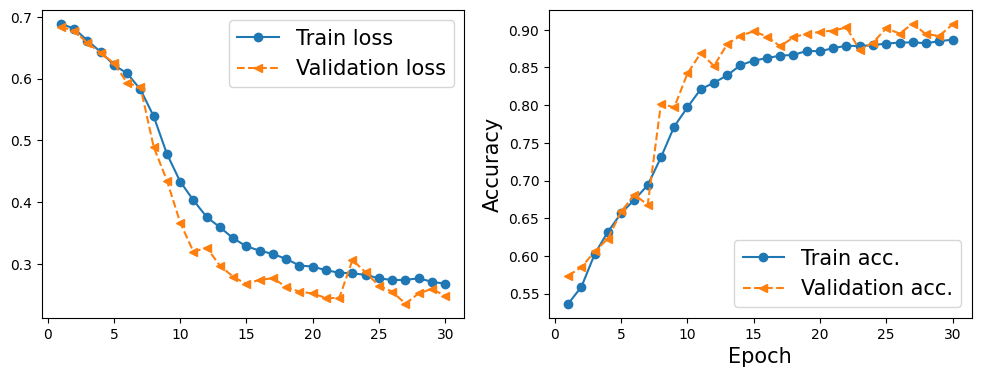

In [89]:
# visualize the learning curve and compare the training and validation loss and accuracies after each epoch:
x_arr = np.arange(len(hist[0]))+1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, list(map(lambda x: x.item(), hist[2])), '-o', label='Train acc.')
ax.plot(x_arr, list(map(lambda x: x.item(), hist[3])), '--<',label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

Once we're happy with the learning curves, we evaluate the model on the hold-out test dataset

In [92]:
accuracy_test = 0
model = model.to('cuda:0')
model.eval()


with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to('cuda:0')
        y_batch = y_batch.to('cuda:0')
        pred = model(x_batch)[:,0]
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()

accuracy_test /= len(test_dl.dataset)

In [93]:
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.9032


In [96]:
x_batch = x_batch.to('cuda:0')
pred = model(x_batch)[:, 0] * 100

In [99]:
pred.detach().clone().cpu()

tensor([ 0.1326,  0.3399,  8.2835, 99.9975,  7.0580, 99.9146,  0.7447, 94.2523,
        99.9654, 99.9501, 99.9498,  2.2195, 14.0506, 99.9788, 12.4468, 82.1912,
        16.1238, 99.9985, 99.9126, 99.9524,  1.2637,  4.4159, 99.8443, 96.1846,
        84.1827,  8.5306])

In [101]:
x_batch.shape

torch.Size([26, 3, 64, 64])

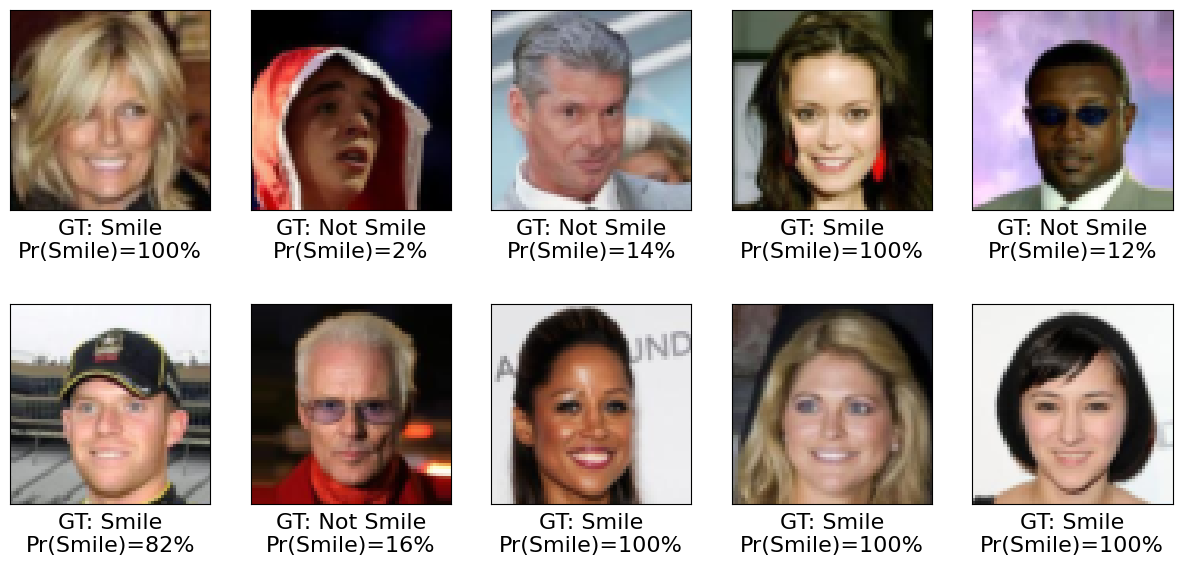

In [100]:
pred = pred.detach().clone().cpu()
x_batch = x_batch.cpu()
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))
    if y_batch[j] == 1:
        label='Smile'
    else:
        label = 'Not Smile'
    ax.text(0.5, -0.15,f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',size=16,horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)
plt.show()